## Colab Setup

In [1]:
import sys

IS_COLAB = 'google.colab' in sys.modules
print(f"Running in Google Colab: {IS_COLAB}")

Running in Google Colab: True


In [2]:
import os
import sys

if IS_COLAB:
    print("Running in Google Colab environment.")
    if os.path.exists('/content/aai521_3proj'):
        print("Repository already exists. Pulling latest changes...")
        %cd /content/aai521_3proj
        !git pull
    else:
        print("Cloning repository...")
        !git clone https://github.com/swapnilprakashpatil/aai521_3proj.git
        %cd aai521_3proj    
    %pip install -r requirements.txt
    sys.path.append('/content/aai521_3proj/src')
    %ls
else:
    print("Running in local environment. Installing packages...")
    %pip install -r ../requirements.txt
    sys.path.append('../src')

Running in Google Colab environment.
Repository already exists. Pulling latest changes...
/content/aai521_3proj
Already up to date.
Already up to date.
dataset/  notebooks/  requirements.txt  src/
dataset/  notebooks/  requirements.txt  src/


## 1. Setup & Imports

In [3]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('../src')

# Reload modules to pick up latest changes
import importlib
if 'dataset' in sys.modules:
    importlib.reload(sys.modules['dataset'])
if 'models' in sys.modules:
    importlib.reload(sys.modules['models'])
if 'config' in sys.modules:
    importlib.reload(sys.modules['config'])

# Import custom modules
import config
from dataset import create_dataloaders, FloodDataset
from models import create_model, UNetPlusPlus, DeepLabV3Plus, SegFormer
from losses import create_loss_function
from metrics import MetricsTracker, SegmentationMetrics
from trainer import Trainer
from experiment_tracking import ExperimentLogger, ExperimentComparator

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch version: 2.9.0+cu126
CUDA available: True
CUDA device: NVIDIA A100-SXM4-40GB
CUDA memory: 42.47 GB


## 2. Data Loading & Exploration

In [4]:
# Create dataloaders
print("Creating dataloaders...")
train_loader, val_loader, test_loader = create_dataloaders(
    train_dir=config.PROCESSED_TRAIN_DIR,
    val_dir=config.PROCESSED_VAL_DIR,
    test_dir=config.PROCESSED_TEST_DIR,
    batch_size=8,  # Match training config
    num_workers=0,  # CRITICAL FIX: Set to 0 to prevent Windows multiprocessing deadlock
    pin_memory=False  # Disable pin_memory when num_workers=0
)

print(f"\nDataset sizes:")
print(f"  Training: {len(train_loader.dataset)} patches ({len(train_loader)} batches)")
print(f"  Validation: {len(val_loader.dataset)} patches ({len(val_loader)} batches)")
print(f"  Test: {len(test_loader.dataset)} patches ({len(test_loader)} batches)")

# Get class weights
class_weights = train_loader.dataset.get_class_weights()
print(f"\nClass weights: {class_weights}")

# Get class distribution
class_dist = train_loader.dataset.get_class_distribution()
print(f"\nClass distribution:")
for i, (class_name, count) in enumerate(zip(config.CLASS_NAMES, class_dist)):
    percentage = (count / class_dist.sum()) * 100
    print(f"  {class_name}: {count:,} ({percentage:.2f}%)")

Creating dataloaders...
Loaded train dataset: 7285 samples

Class distribution (train):
  Class 0: 1,860,991,567 pixels (97.45%), weight: 0.0945
  Class 1: 31,784,864 pixels (1.66%), weight: 0.7227
  Class 2: 8,851,035 pixels (0.46%), weight: 1.3696
  Class 3: 0 pixels (0.00%), weight: 0.0932
  Class 4: 0 pixels (0.00%), weight: 0.0932
  Class 5: 1,849,705 pixels (0.10%), weight: 2.9959
  Class 6: 6,241,869 pixels (0.33%), weight: 1.6309
Loaded val dataset: 1069 samples

Class distribution (val):
  Class 0: 274,496,415 pixels (97.95%), weight: 0.0939
  Class 1: 3,162,106 pixels (1.13%), weight: 0.8752
  Class 2: 1,445,230 pixels (0.52%), weight: 1.2946
  Class 3: 0 pixels (0.00%), weight: 0.0930
  Class 4: 0 pixels (0.00%), weight: 0.0930
  Class 5: 300,377 pixels (0.11%), weight: 2.8397
  Class 6: 827,808 pixels (0.30%), weight: 1.7106
Loaded test dataset: 3573 samples

Class distribution (test):
  Class 0: 936,640,512 pixels (100.00%), weight: 1.0000
  Class 1: 0 pixels (0.00%), weig

### Visualize Class Distribution

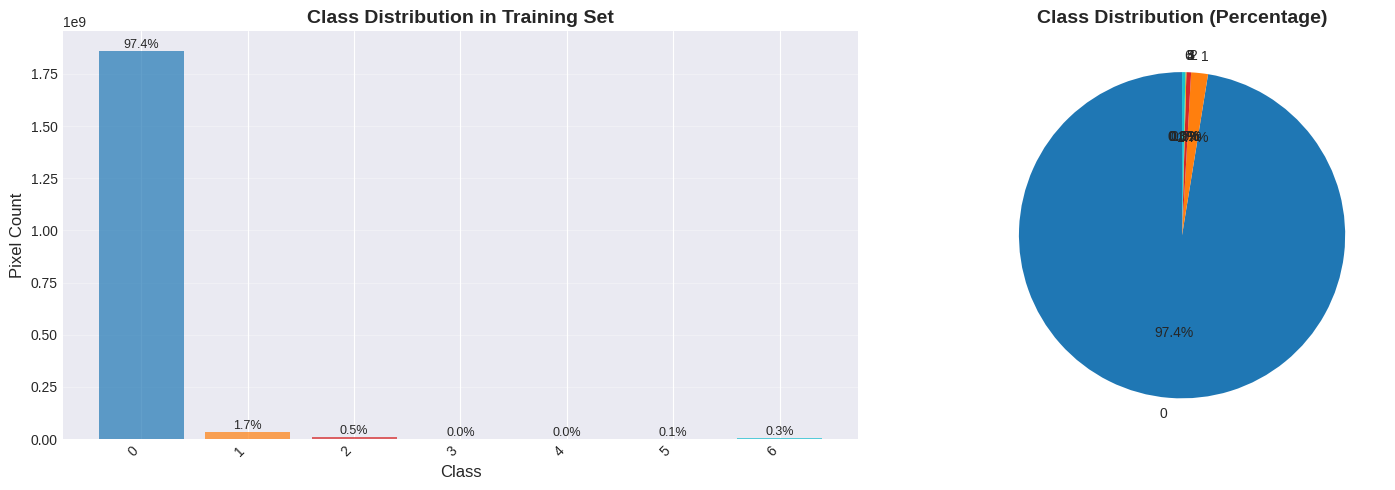

In [5]:
# Plot class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Bar plot
colors = plt.cm.tab10(np.linspace(0, 1, len(config.CLASS_NAMES)))
bars = ax1.bar(range(len(config.CLASS_NAMES)), class_dist, color=colors, alpha=0.7)
ax1.set_xlabel('Class', fontsize=12)
ax1.set_ylabel('Pixel Count', fontsize=12)
ax1.set_title('Class Distribution in Training Set', fontsize=14, fontweight='bold')
ax1.set_xticks(range(len(config.CLASS_NAMES)))
ax1.set_xticklabels(config.CLASS_NAMES, rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Add percentage labels
for i, (bar, count) in enumerate(zip(bars, class_dist)):
    height = bar.get_height()
    percentage = (count / class_dist.sum()) * 100
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{percentage:.1f}%',
            ha='center', va='bottom', fontsize=9)

# Pie chart
ax2.pie(class_dist, labels=config.CLASS_NAMES, autopct='%1.1f%%',
        colors=colors, startangle=90)
ax2.set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### Visualize Sample Data

Batch shape: torch.Size([8, 6, 512, 512])
Mask shape: torch.Size([8, 512, 512])
Image range: [-2.118, -2.018]
Mask classes: [0, 1, 6]


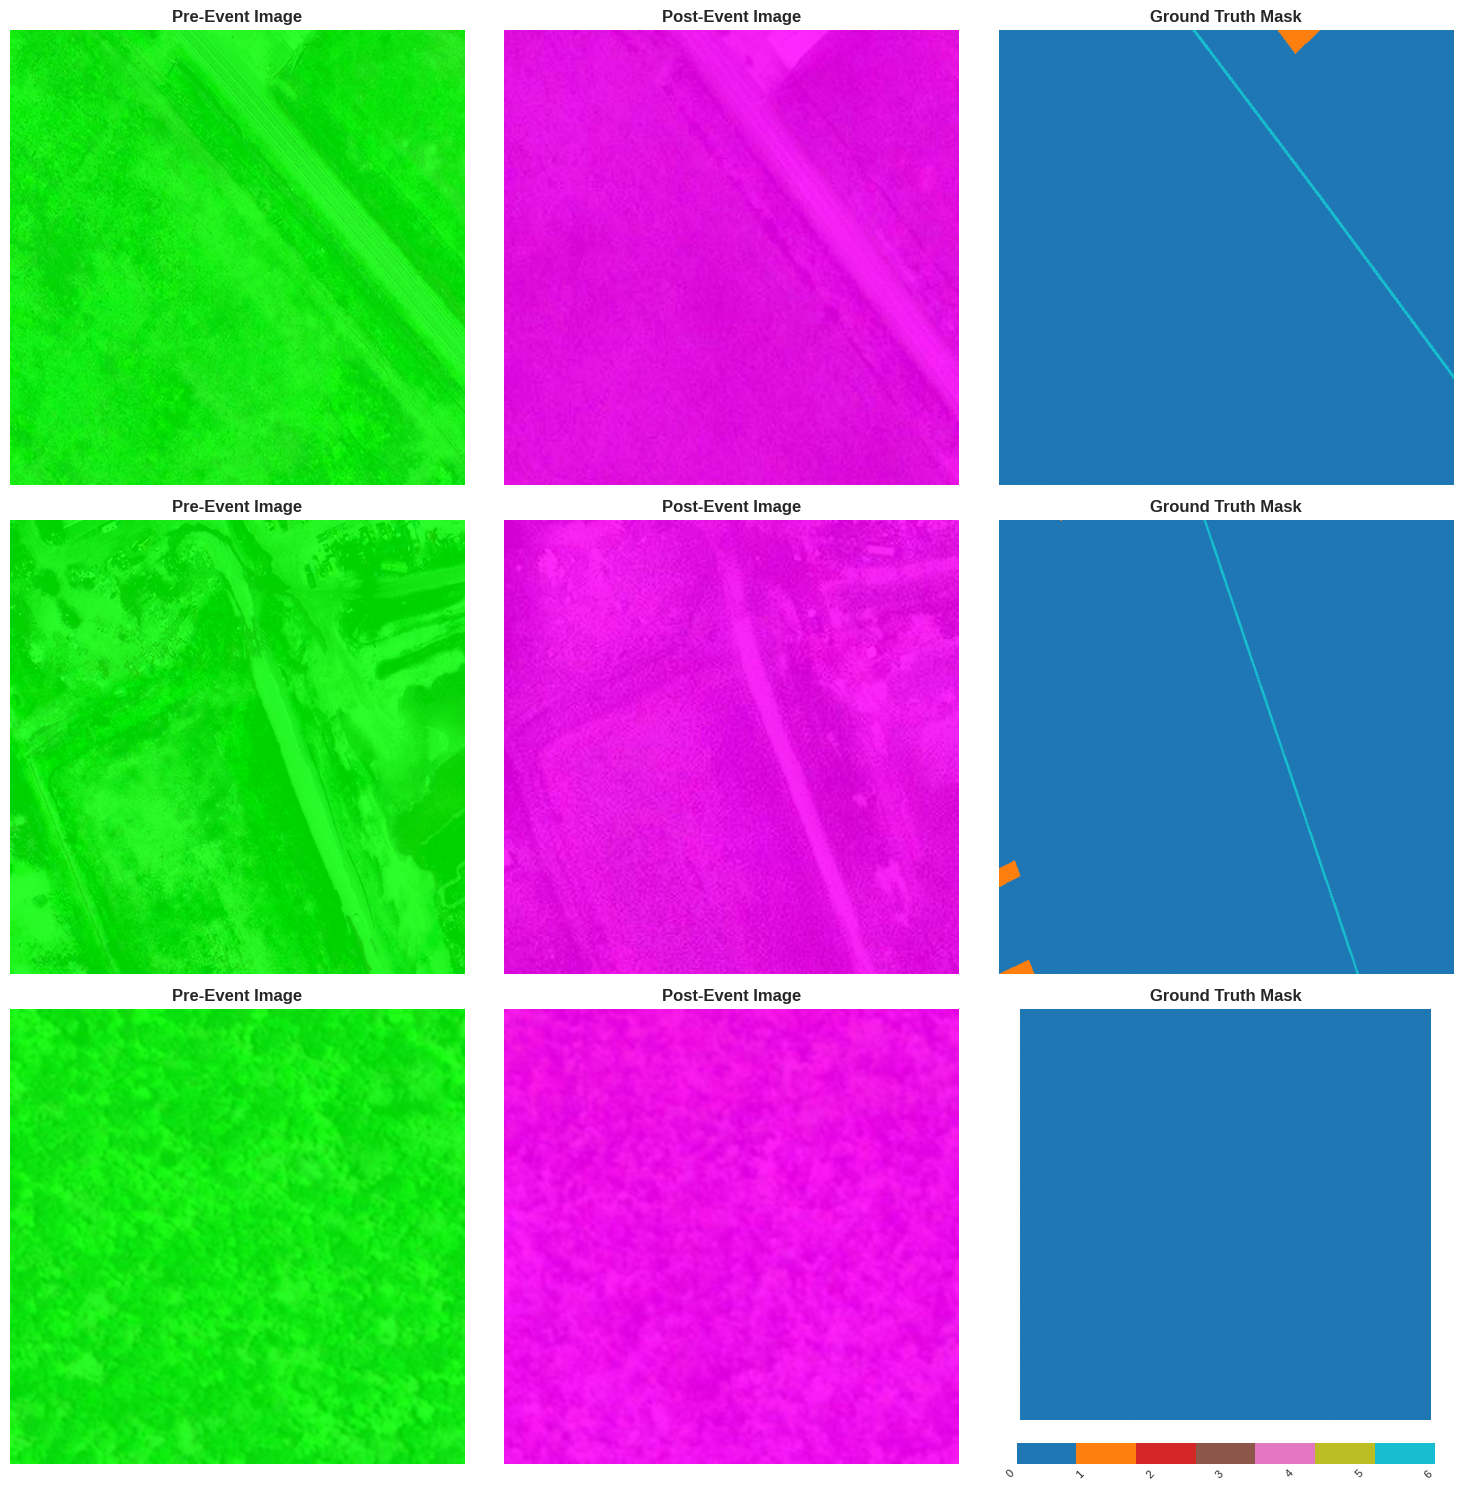

In [6]:
# Get a batch of training data
train_iter = iter(train_loader)
batch = next(train_iter)
images = batch['image']
masks = batch['mask']

print(f"Batch shape: {images.shape}")
print(f"Mask shape: {masks.shape}")
print(f"Image range: [{images.min():.3f}, {images.max():.3f}]")
print(f"Mask classes: {masks.unique().tolist()}")

# Visualize samples
def visualize_samples(images, masks, num_samples=3):
    """Visualize pre/post images and masks."""
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    # Color map for masks
    cmap = plt.cm.get_cmap('tab10', len(config.CLASS_NAMES))
    
    for i in range(num_samples):
        # Pre-event image (first 3 channels)
        pre_img = images[i, :3].permute(1, 2, 0).numpy()
        pre_img = (pre_img - pre_img.min()) / (pre_img.max() - pre_img.min() + 1e-8)
        
        # Post-event image (last 3 channels)
        post_img = images[i, 3:].permute(1, 2, 0).numpy()
        post_img = (post_img - post_img.min()) / (post_img.max() - post_img.min() + 1e-8)
        
        # Mask
        mask = masks[i].numpy()
        
        # Plot pre-event
        axes[i, 0].imshow(pre_img)
        axes[i, 0].set_title('Pre-Event Image', fontsize=12, fontweight='bold')
        axes[i, 0].axis('off')
        
        # Plot post-event
        axes[i, 1].imshow(post_img)
        axes[i, 1].set_title('Post-Event Image', fontsize=12, fontweight='bold')
        axes[i, 1].axis('off')
        
        # Plot mask
        mask_plot = axes[i, 2].imshow(mask, cmap=cmap, vmin=0, vmax=len(config.CLASS_NAMES)-1)
        axes[i, 2].set_title('Ground Truth Mask', fontsize=12, fontweight='bold')
        axes[i, 2].axis('off')
        
        # Add colorbar to last mask
        if i == num_samples - 1:
            cbar = plt.colorbar(mask_plot, ax=axes[i, 2], orientation='horizontal', 
                              pad=0.05, fraction=0.046)
            cbar.set_ticks(range(len(config.CLASS_NAMES)))
            cbar.set_ticklabels(config.CLASS_NAMES, rotation=45, ha='right', fontsize=8)
    
    plt.tight_layout()
    plt.show()

visualize_samples(images, masks, num_samples=3)

## 3. Model Architecture Overview

In [7]:
# Create models for architecture overview
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# List of all models to train
ALL_MODELS = ['unet++', 'deeplabv3+', 'segformer', 'fc_siam_diff', 'siamese_unet++', 'stanet']

models_info = []

for model_name in ALL_MODELS:
    model = create_model(
        model_name=model_name,
        in_channels=6 if 'siamese' not in model_name.lower() else 3,
        num_classes=config.NUM_CLASSES,
        **config.MODEL_CONFIGS.get(model_name, {})
    )
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    models_info.append({
        'Model': model_name.upper(),
        'Total Parameters': f"{total_params:,}",
        'Trainable Parameters': f"{trainable_params:,}",
        'Size (MB)': f"{total_params * 4 / 1e6:.2f}"
    })
    
    del model

# Display as table
models_df = pd.DataFrame(models_info)
print("\n" + "="*80)
print("MODEL ARCHITECTURE COMPARISON")
print("="*80)
print(models_df.to_string(index=False))
print("="*80)

UNet++ initialized:
  Encoder: resnet34
  Input channels: 6
  Output classes: 7
  Pretrained: imagenet
  Deep supervision: False
DeepLabV3+ initialized:
  Encoder: resnet50
  Input channels: 6
  Output classes: 7
  Output stride: 16
  Pretrained: imagenet
DeepLabV3+ initialized:
  Encoder: resnet50
  Input channels: 6
  Output classes: 7
  Output stride: 16
  Pretrained: imagenet


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([7]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([7, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SegFormer initialized:
  Model: nvidia/segformer-b0-finetuned-ade-512-512
  Input channels: 6
  Output classes: 7
  Pretrained: True
FC-Siam-Diff initialized:
  Encoder: resnet34
  Optimized for change detection
FC-Siam-Diff initialized:
  Encoder: resnet34
  Optimized for change detection
Siamese U-Net++ initialized:
  Encoder: resnet34
  Fusion: concat
  Output classes: 7
Siamese U-Net++ initialized:
  Encoder: resnet34
  Fusion: concat
  Output classes: 7
STANet initialized with spatial-temporal attention

MODEL ARCHITECTURE COMPARISON
         Model Total Parameters Trainable Parameters Size (MB)
        UNET++       26,088,887           26,088,887    104.36
    DEEPLABV3+       26,688,535           26,688,535    106.75
     SEGFORMER        3,720,647            3,720,647     14.88
  FC_SIAM_DIFF       24,584,519           24,584,519     98.34
SIAMESE_UNET++       26,780,167           26,780,167    107.12
        STANET       24,890,824           24,890,824     99.56
STANet initial

## 4. Training Configuration

In [8]:
# Training configuration for all models
TRAINING_CONFIG = {
    'batch_size': 8,  # Reduced to safe size for stability
    'num_epochs': 50,
    'learning_rate': 5e-5,
    'weight_decay': 1e-4,
    'use_amp': True,
    'gradient_clip': 1.0,
    'early_stopping_patience': 15,
    'loss_type': 'combined',
    'scheduler_type': 'plateau',
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'gradient_accumulation_steps': 4,  # Effective batch size = 32
    'print_every_n_epochs': 5,
    # Loss weights for class imbalance
    'ce_weight': 0.1,
    'dice_weight': 2.0,
    'focal_weight': 3.0,
    'focal_gamma': 3.0
}

print("\n" + "="*80)
print("TRAINING CONFIGURATION")
print("="*80)
for key, value in TRAINING_CONFIG.items():
    print(f"  {key}: {value}")
print(f"\n  Effective batch size: {TRAINING_CONFIG['batch_size'] * TRAINING_CONFIG['gradient_accumulation_steps']}")
print("="*80)


TRAINING CONFIGURATION
  batch_size: 8
  num_epochs: 50
  learning_rate: 5e-05
  weight_decay: 0.0001
  use_amp: True
  gradient_clip: 1.0
  early_stopping_patience: 15
  loss_type: combined
  scheduler_type: plateau
  device: cuda
  gradient_accumulation_steps: 4
  print_every_n_epochs: 5
  ce_weight: 0.1
  dice_weight: 2.0
  focal_weight: 3.0
  focal_gamma: 3.0

  Effective batch size: 32


In [9]:
# Check GPU memory and recommend optimal batch size
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gpu_props = torch.cuda.get_device_properties(0)
    total_memory_gb = gpu_props.total_memory / 1e9
    
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total Memory: {total_memory_gb:.2f} GB")
    
    # Rough estimation for batch size recommendation
    if total_memory_gb >= 24:
        recommended_batch = "24-32 (you have plenty of VRAM)"
    elif total_memory_gb >= 16:
        recommended_batch = "16-24 (current: 16 is good)"
    elif total_memory_gb >= 12:
        recommended_batch = "12-16 (current: 16 might be tight)"
    elif total_memory_gb >= 8:
        recommended_batch = "8-12 (reduce to 12 if OOM)"
    else:
        recommended_batch = "4-8 (reduce to 8 and increase grad accumulation)"
    
    print(f"Recommended batch size: {recommended_batch}")
    print(f"Current batch size: {TRAINING_CONFIG['batch_size']}")
    print(f"Effective batch size: {TRAINING_CONFIG['batch_size'] * TRAINING_CONFIG['gradient_accumulation_steps']}")
    
    # Monitor current GPU state
    torch.cuda.empty_cache()
    allocated = torch.cuda.memory_allocated() / 1e9
    reserved = torch.cuda.memory_reserved() / 1e9
    print(f"\nCurrent GPU Usage:")
    print(f"  Allocated: {allocated:.2f} GB")
    print(f"  Reserved: {reserved:.2f} GB")
    print(f"  Free: {total_memory_gb - reserved:.2f} GB")
else:
    print("No GPU available - using CPU")

GPU: NVIDIA A100-SXM4-40GB
Total Memory: 42.47 GB
Recommended batch size: 24-32 (you have plenty of VRAM)
Current batch size: 8
Effective batch size: 32

Current GPU Usage:
  Allocated: 0.00 GB
  Reserved: 0.00 GB
  Free: 42.47 GB


## 5. Training Function

In [10]:
def train_model(model_name, config_dict, train_loader, val_loader, class_weights):
    """Train a single model and return training history."""
    print(f"\n{'='*80}")
    print(f"Training {model_name.upper()}")
    print(f"{'='*80}\n")
    
    # CUDA optimizations
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
    
    # Create output directory
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    output_dir = Path('../outputs/training') / f'{model_name}_{timestamp}'
    output_dir.mkdir(parents=True, exist_ok=True)
    checkpoint_dir = output_dir / 'checkpoints'
    checkpoint_dir.mkdir(exist_ok=True)
    
    # Create model
    model = create_model(
        model_name=model_name,
        in_channels=6 if 'siamese' not in model_name.lower() else 3,
        num_classes=config.NUM_CLASSES,
        **config.MODEL_CONFIGS.get(model_name, {})
    )
    model = model.to(config_dict['device'])
    
    # Use torch.compile if available
    if hasattr(torch, 'compile') and config_dict['device'] == 'cuda':
        try:
            model = torch.compile(model, mode='default')
        except Exception as e:
            pass
    
    # Create loss function
    loss_fn = create_loss_function(
        loss_type=config_dict['loss_type'],
        num_classes=config.NUM_CLASSES,
        class_weights=class_weights.to(config_dict['device']),
        device=config_dict['device'],
        ce_weight=config_dict.get('ce_weight', 0.1),
        dice_weight=config_dict.get('dice_weight', 2.0),
        focal_weight=config_dict.get('focal_weight', 3.0),
        focal_gamma=config_dict.get('focal_gamma', 3.0)
    )
    
    # Create optimizer
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config_dict['learning_rate'],
        weight_decay=config_dict['weight_decay'],
        betas=(0.9, 0.999),
        eps=1e-8
    )
    
    # Create scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
    
    # Create experiment logger
    logger = ExperimentLogger(
        log_dir=Path('../outputs/tensorboard'),
        experiment_name=f'{model_name}_{timestamp}'
    )
    logger.log_hyperparameters(config_dict)
    
    # Create trainer
    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        loss_fn=loss_fn,
        num_classes=config.NUM_CLASSES,
        device=config_dict['device'],
        checkpoint_dir=checkpoint_dir,
        experiment_name=f'{model_name}_{timestamp}',
        use_amp=config_dict['use_amp'],
        gradient_clip_val=config_dict['gradient_clip'],
        early_stopping_patience=config_dict['early_stopping_patience'],
        gradient_accumulation_steps=config_dict.get('gradient_accumulation_steps', 1),
        class_names=config.CLASS_NAMES
    )
    
    # Train
    history = trainer.train(num_epochs=config_dict['num_epochs'])
    
    # Print final summary
    best_epoch = max(range(len(history['val_iou'])), key=lambda i: history['val_iou'][i])
    print(f"\n{'='*80}")
    print(f"FINAL RESULTS - {model_name.upper()}")
    print(f"{'='*80}")
    print(f"Best epoch: {best_epoch + 1}/{len(history['val_iou'])}")
    print(f"\nBest validation metrics:")
    print(f"  IoU:  {history['val_iou'][best_epoch]:.4f}")
    print(f"  Dice: {history['val_dice'][best_epoch]:.4f}")
    print(f"  F1:   {history['val_f1'][best_epoch]:.4f}")
    
    # Per-class metrics if available
    if 'val_iou_per_class' in history:
        print(f"\nPer-class IoU (Best Epoch):")
        for i, (class_name, iou) in enumerate(zip(config.CLASS_NAMES, history['val_iou_per_class'][best_epoch])):
            print(f"  {class_name}: {iou:.4f}")
    
    print(f"{'='*80}\n")
    
    # Log metrics to TensorBoard
    for epoch in range(len(history['train_loss'])):
        logger.log_scalar('Loss/train', history['train_loss'][epoch], epoch)
        logger.log_scalar('Loss/val', history['val_loss'][epoch], epoch)
        logger.log_scalar('IoU/train', history['train_iou'][epoch], epoch)
        logger.log_scalar('IoU/val', history['val_iou'][epoch], epoch)
    
    logger.close()
    
    # Save history
    history_json = {}
    for key, values in history.items():
        if isinstance(values, list):
            history_json[key] = [float(v) if hasattr(v, 'item') else v for v in values]
        else:
            history_json[key] = values
    
    with open(output_dir / 'training_history.json', 'w') as f:
        json.dump(history_json, f, indent=2)
    
    print(f"[SAVED] Checkpoints: {checkpoint_dir}")
    print(f"[SAVED] Training history: {output_dir / 'training_history.json'}\n")
    
    return history, output_dir

## 6. Train All Models

In [ ]:
# Clear GPU cache before training
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    import gc
    gc.collect()
    
    # Check available memory
    free_memory = torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated()
    free_gb = free_memory / 1e9
    print(f"GPU Memory Available: {free_gb:.2f} GB")
    
    if free_gb < 2.0:
        print("WARNING: Less than 2GB free GPU memory!")
        print("Please restart kernel and re-run from the beginning.")
    else:
        print("GPU memory check passed. Starting training...")
else:
    print("No GPU available - training will be slow on CPU")

GPU Memory Available: 42.47 GB
GPU memory check passed. Starting training...


In [12]:
# DIAGNOSTIC: Test if dataloader can iterate
print("Testing dataloader iteration...")
try:
    test_iter = iter(train_loader)
    print("Created iterator successfully")
    
    import time
    start = time.time()
    print("Fetching first batch...")
    test_batch = next(test_iter)
    elapsed = time.time() - start
    
    print(f"SUCCESS: First batch loaded in {elapsed:.2f} seconds")
    print(f"Batch shape: {test_batch['image'].shape}")
    print(f"Mask shape: {test_batch['mask'].shape}")
    del test_batch, test_iter
except Exception as e:
    print(f"ERROR: Failed to load first batch - {str(e)}")
    import traceback
    traceback.print_exc()

Testing dataloader iteration...
Created iterator successfully
Fetching first batch...
SUCCESS: First batch loaded in 0.37 seconds
Batch shape: torch.Size([8, 6, 512, 512])
Mask shape: torch.Size([8, 512, 512])
SUCCESS: First batch loaded in 0.37 seconds
Batch shape: torch.Size([8, 6, 512, 512])
Mask shape: torch.Size([8, 512, 512])


In [ ]:
# CRITICAL FIX: Reload trainer module with deadlock fix
import importlib
if 'trainer' in sys.modules:
    importlib.reload(sys.modules['trainer'])
    print("Trainer module reloaded with Windows deadlock fix")
else:
    from trainer import Trainer
    print("Trainer module loaded with Windows deadlock fix")

print("\nFix applied: Disabled inner tqdm progress bars that caused deadlock with num_workers=0")
print("You will now see only the overall epoch progress bar, not per-batch progress.")

### 6.1 U-Net++

In [ ]:
# Train U-Net++
unet_history, unet_output_dir = train_model(
    'unet++',
    TRAINING_CONFIG,
    train_loader,
    val_loader,
    class_weights
)


Training UNET++

UNet++ initialized:
  Encoder: resnet34
  Input channels: 6
  Output classes: 7
  Pretrained: imagenet
  Deep supervision: False
UNet++ initialized:
  Encoder: resnet34
  Input channels: 6
  Output classes: 7
  Pretrained: imagenet
  Deep supervision: False
Combined Loss initialized:
  CE weight:    0.1
  Dice weight:  2.0
  Focal weight: 3.0
  Class weights: [0.09445118 0.72271895 1.3695648  0.09323841 0.09323841 2.995907
 1.630881  ]

Trainer initialized:
  Experiment: unet++_20251201_035235
  Device: cuda
  Mixed precision: True
  Gradient clipping: 1.0
  Early stopping patience: 15
  Checkpoint dir: ../outputs/training/unet++_20251201_035235/checkpoints/unet++_20251201_035235

Starting training for 50 epochs

Combined Loss initialized:
  CE weight:    0.1
  Dice weight:  2.0
  Focal weight: 3.0
  Class weights: [0.09445118 0.72271895 1.3695648  0.09323841 0.09323841 2.995907
 1.630881  ]

Trainer initialized:
  Experiment: unet++_20251201_035235
  Device: cuda
  M

Training Progress:   0%|                                                                      | 0/50 [00:00<?, ?epoch/s]

Training Progress:   0%|                                                                      | 0/50 [01:11<?, ?epoch/s]



KeyboardInterrupt: 

### 6.2 DeepLabV3+

In [ ]:
# Train DeepLabV3+
deeplab_history, deeplab_output_dir = train_model(
    'deeplabv3+',
    TRAINING_CONFIG,
    train_loader,
    val_loader,
    class_weights
)

### 6.3 SegFormer

In [ ]:
# Train SegFormer
segformer_history, segformer_output_dir = train_model(
    'segformer',
    TRAINING_CONFIG,
    train_loader,
    val_loader,
    class_weights
)

### 6.4 FC-Siam-Diff

In [ ]:
# Train FC-Siam-Diff
fcsiamdiff_history, fcsiamdiff_output_dir = train_model(
    'fc_siam_diff',
    TRAINING_CONFIG,
    train_loader,
    val_loader,
    class_weights
)

### 6.5 Siamese U-Net++

In [ ]:
# Train Siamese U-Net++
siamese_unet_history, siamese_unet_output_dir = train_model(
    'siamese_unet++',
    TRAINING_CONFIG,
    train_loader,
    val_loader,
    class_weights
)

### 6.6 STANet

In [ ]:
# Train STANet
stanet_history, stanet_output_dir = train_model(
    'stanet',
    TRAINING_CONFIG,
    train_loader,
    val_loader,
    class_weights
)

## 7. Training Metrics Visualization

In [ ]:
def plot_training_history(history, model_name, save_path=None):
    """Plot training history for a single model."""
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss plot
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title(f'{model_name} - Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # IoU plot
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(epochs, history['train_iou'], 'b-', label='Train IoU', linewidth=2)
    ax2.plot(epochs, history['val_iou'], 'r-', label='Val IoU', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=11)
    ax2.set_ylabel('IoU', fontsize=11)
    ax2.set_title('Mean IoU', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # Dice plot
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.plot(epochs, history['train_dice'], 'b-', label='Train Dice', linewidth=2)
    ax3.plot(epochs, history['val_dice'], 'r-', label='Val Dice', linewidth=2)
    ax3.set_xlabel('Epoch', fontsize=11)
    ax3.set_ylabel('Dice', fontsize=11)
    ax3.set_title('Mean Dice Coefficient', fontsize=12, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    plt.suptitle(f'{model_name} Training Metrics', fontsize=16, fontweight='bold', y=0.995)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Print best metrics
    best_epoch = max(range(len(history['val_iou'])), key=lambda i: history['val_iou'][i])
    print(f"\n{'='*80}")
    print(f"{model_name} - Best Validation Metrics (Epoch {best_epoch + 1})")
    print(f"{'='*80}")
    print(f"Mean IoU: {history['val_iou'][best_epoch]:.4f}")
    print(f"Mean Dice: {history['val_dice'][best_epoch]:.4f}")
    print(f"Mean F1: {history['val_f1'][best_epoch]:.4f}")
    print(f"{'='*80}\n")

## 8. Model Comparison

In [ ]:
# Compare all models
def compare_models(histories, model_names):
    """Compare multiple models."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    
    # Plot 1: Validation Loss
    for history, name, color in zip(histories, model_names, colors):
        epochs = range(1, len(history['val_loss']) + 1)
        axes[0, 0].plot(epochs, history['val_loss'], label=name, linewidth=2, color=color)
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Loss', fontsize=12)
    axes[0, 0].set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Validation IoU
    for history, name, color in zip(histories, model_names, colors):
        epochs = range(1, len(history['val_iou']) + 1)
        axes[0, 1].plot(epochs, history['val_iou'], label=name, linewidth=2, color=color)
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('IoU', fontsize=12)
    axes[0, 1].set_title('Validation Mean IoU Comparison', fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Validation Dice
    for history, name, color in zip(histories, model_names, colors):
        epochs = range(1, len(history['val_dice']) + 1)
        axes[1, 0].plot(epochs, history['val_dice'], label=name, linewidth=2, color=color)
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('Dice', fontsize=12)
    axes[1, 0].set_title('Validation Mean Dice Comparison', fontsize=14, fontweight='bold')
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Best Metrics Bar Chart
    x = np.arange(len(model_names))
    width = 0.25
    
    # Get best metrics for each model
    iou_values = []
    dice_values = []
    f1_values = []
    
    for history in histories:
        best_epoch = max(range(len(history['val_iou'])), key=lambda i: history['val_iou'][i])
        iou_values.append(history['val_iou'][best_epoch])
        dice_values.append(history['val_dice'][best_epoch])
        f1_values.append(history['val_f1'][best_epoch])
    
    axes[1, 1].bar(x - width, iou_values, width, label='IoU', alpha=0.8)
    axes[1, 1].bar(x, dice_values, width, label='Dice', alpha=0.8)
    axes[1, 1].bar(x + width, f1_values, width, label='F1', alpha=0.8)
    
    axes[1, 1].set_xlabel('Model', fontsize=12)
    axes[1, 1].set_ylabel('Score', fontsize=12)
    axes[1, 1].set_title('Best Validation Metrics Comparison', fontsize=14, fontweight='bold')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(model_names, rotation=45, ha='right')
    axes[1, 1].legend(fontsize=11)
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print comparison table
    print(f"\n{'='*100}")
    print("MODEL COMPARISON - BEST VALIDATION METRICS")
    print(f"{'='*100}")
    print(f"{'Model':<20} {'Best Epoch':<12} {'Mean IoU':<12} {'Mean Dice':<12} {'Mean F1':<12}")
    print(f"{'-'*100}")
    
    for name, history in zip(model_names, histories):
        best_epoch = max(range(len(history['val_iou'])), key=lambda i: history['val_iou'][i])
        
        print(f"{name:<20} {best_epoch+1:<12} {history['val_iou'][best_epoch]:<12.4f} "
              f"{history['val_dice'][best_epoch]:<12.4f} {history['val_f1'][best_epoch]:<12.4f}")
    
    print(f"{'='*100}\n")

# Compare all models
compare_models(
    [unet_history, deeplab_history, segformer_history, fcsiamdiff_history, siamese_unet_history, stanet_history],
    ['U-Net++', 'DeepLabV3+', 'SegFormer', 'FC-Siam-Diff', 'Siamese U-Net++', 'STANet']
)

## 9. TensorBoard Visualization

In [ ]:
# Launch TensorBoard to view training metrics
print("To view TensorBoard:")
print("1. Run in terminal: tensorboard --logdir=../outputs/tensorboard --port=6006")
print("2. Open browser: http://localhost:6006")
print("\nTensorBoard shows:")
print("  - Training/validation loss curves")
print("  - IoU, Dice, F1 metrics over time")
print("  - Per-class performance")
print("  - Learning rate schedules")
print("  - Model graphs")